<a href="https://colab.research.google.com/github/TobiasJacob/Graffiti/blob/master/notebooks/Point_Detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloader

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 9.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!cp "/content/drive/My Drive/AIDA tracks at sea/datasets/dataset1.zip" dataset1.zip

In [ ]:
!unzip dataset1.zip -d .

Archive:  dataset1.zip
   creating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/17-03525.png  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/17-03525.pos  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/17-03550.png  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/17-03550.pos  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/17-03575.png  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/17-03575.pos  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/21-00025.png  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/21-00025.pos  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/21-00050.png  
  inflating: ./content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/21-00050.pos  
 

# Dataloader

In [ ]:
import os
from fastai.vision.all import *
import numpy as np

In [ ]:
dsDir = "/content/content/drive/My Drive/AIDA tracks at sea/datasets/dataset1"

In [ ]:
len(os.listdir(dsDir))

3606

In [ ]:
lbls = get_files(dsDir, extensions='.pos')
imgs = get_image_files(dsDir)
# test_eq(len(lbls), len(imgs))

In [ ]:
!nvidia-smi

Tue Nov 17 06:08:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def img2kpts(f): return f'{str(f)[:-4]}.pos'

In [ ]:
fname = imgs[0]

In [ ]:
img = PILImage.create(fname)

In [ ]:
kpts = np.genfromtxt(img2kpts(fname), delimiter=',')
kpts

array([597.43704739, 430.16282438, 112.69474487])

In [ ]:
def sep_points(coords:array):
  "Seperate a set of points to groups"
  kpts = []
  kpts.append([coords[0], coords[1]])
  return tensor(kpts)
pnts = sep_points(kpts); pnts

tensor([[597.4371, 430.1628]])

In [ ]:
def get_y(f:Path):
  "Get keypoints for `f` image"
  pts = np.genfromtxt(img2kpts(f), delimiter=',')
  return sep_points(pts)

In [ ]:
bad_imgs = []

In [ ]:
#im = PILImage.create(imgs[0])
#for name in imgs:
#  y = get_y(name)
#  for x in y:
#    if x[0] < im.size[0]:
#      if x[0] < 0:
#        bad_imgs.append(name)
#      if x[1] < im.size[1]:
#        if x[1] < 0:
#          bad_imgs.append(name)
#      else:
#        bad_imgs.append(name)
#    else:
#      bad_imgs.append(name)

In [ ]:
len(bad_imgs)

0

In [ ]:
len(set(bad_imgs))

0

In [ ]:
for name in list(set(bad_imgs)):
  name.unlink()

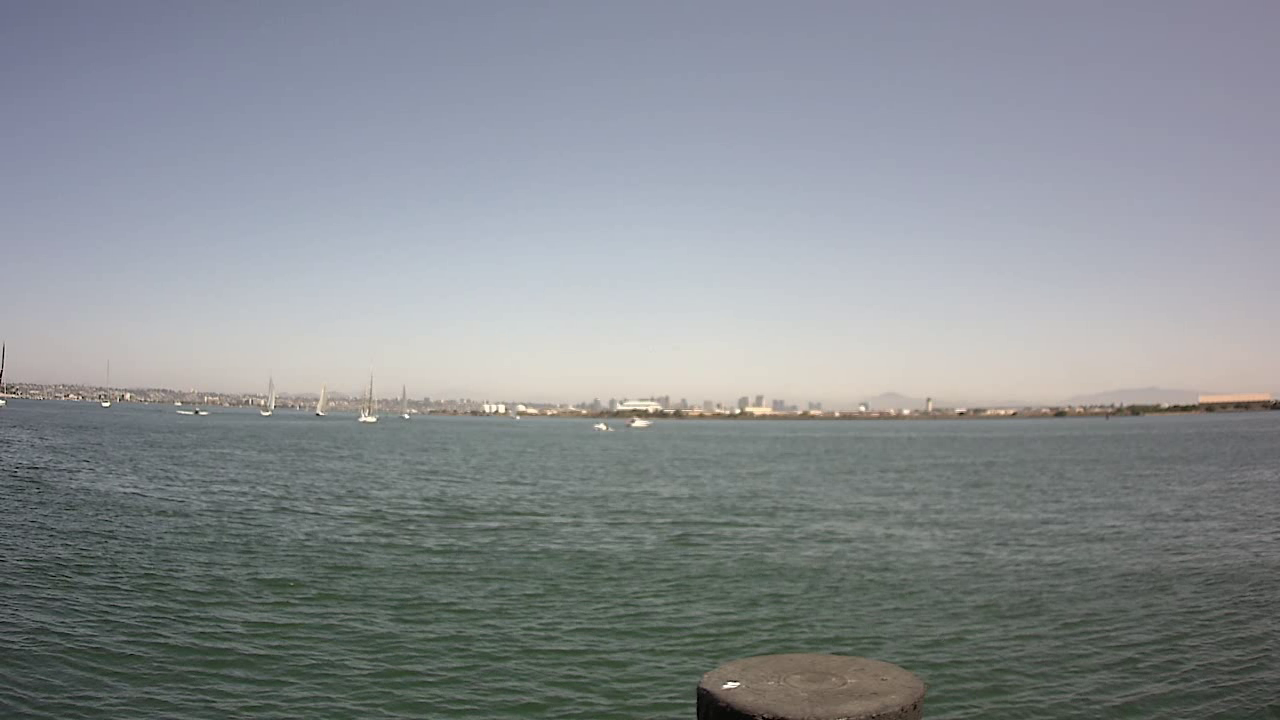

In [ ]:
imgs = get_image_files(dsDir)
fname = imgs[0]
img = PILImage.create(fname)
img

In [ ]:
def get_ip(img:PILImage, pts:array): return TensorPoint(pts, sz=img.size)

In [ ]:
ip = get_y(fname); ip

tensor([[597.4371, 430.1628]])

In [ ]:
tp = get_ip(img, ip)

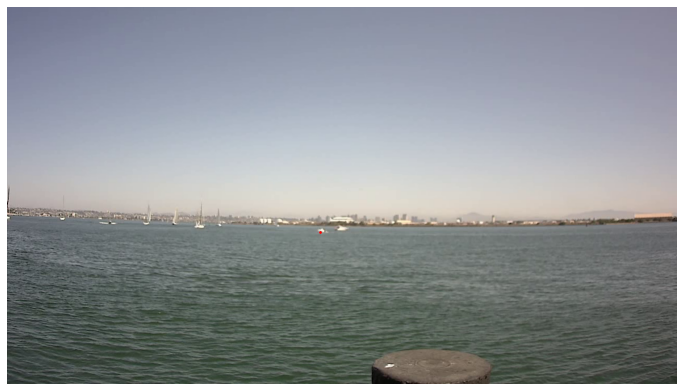

In [ ]:
ax = img.show(figsize=(12,12))
tp.show(ctx=ax)

In [ ]:
class ClampBatch(Transform):
  "Clamp points to a minimum and maximum in a batch"
  order = 4
  def __init__(self, min=-1, max=1, **kwargs):
    super().__init__(**kwargs)
    self.min, self.max = min, max
  def encodes(self, x:(TensorPoint)):
    for i, sets in enumerate(x):
      for j, pair in enumerate(sets):
        cpnt = torch.clamp(pair, self.min, self.max)
        if any(cpnt>=1) or any(cpnt<=-1):
          x[i][j] = tensor([-1,-1])
    return x

In [ ]:
item_tfms = [Resize(448, method='squish')]
batch_tfms = [Flip(), Rotate(), Zoom(), Warp(), ClampBatch()]

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [ ]:
bs=16

In [ ]:
dblock.summary(dsDir)

Setting-up type transforms pipelines
Found 1803 items
2 datasets of sizes 1443,360
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> TensorPoint.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/11-02875.png
    applying PILBase.create gives
      PILImage mode=RGB size=1280x720
  Pipeline: get_y -> TensorPoint.create
    starting from
      /content/content/drive/My Drive/AIDA tracks at sea/datasets/dataset1/11-02875.png
    applying get_y gives
      Tensor of size 1x2
    applying TensorPoint.create gives
      TensorPoint of size 1x2

Final sample: (PILImage mode=RGB size=1280x720, TensorPoint([[475.2640, 427.4950]]))


Setting up after_item: Pipeline: PointScaler -> Resize -- {'size': (448, 448), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: ClampBatch -> In

In [ ]:
dls = dblock.dataloaders(dsDir, bs=bs)

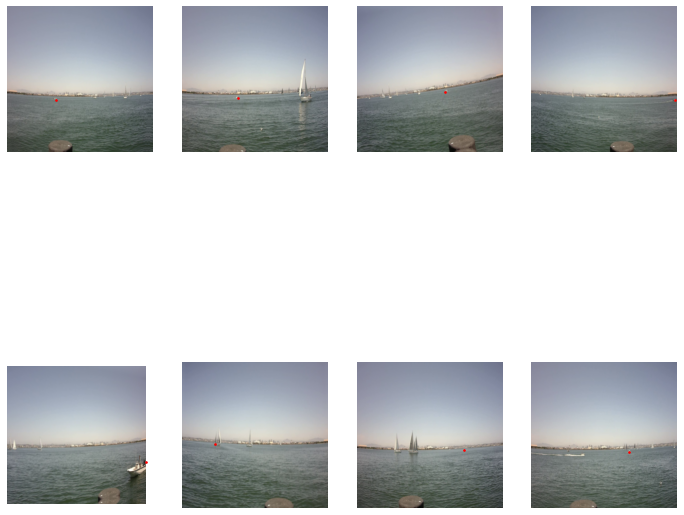

In [ ]:
dls.show_batch(max_n=8, figsize=(12,12))

In [ ]:
dls.c = dls.train.after_item.c

In [ ]:
dls.c

2

# Linear regression

In [ ]:
body = create_body(resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
body

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
head = create_head(nf=1024, n_out=2); head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
arch = nn.Sequential(body, head)

In [ ]:
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

In [ ]:
arch[1:]

Sequential(
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): Flatten(full=False)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=2, bias=False)
  )
)

In [ ]:
apply_init(arch[1], nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, arch, loss_func=MSELossFlat(), splitter = _resnet_split,
                opt_func=ranger)

In [ ]:
learn.summary()

Sequential (Input shape: ['24 x 3 x 448 x 448'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               24 x 64 x 224 x 224  9,408      True      
________________________________________________________________
BatchNorm2d          24 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 24 x 64 x 224 x 224  0          False     
________________________________________________________________
MaxPool2d            24 x 64 x 112 x 112  0          False     
________________________________________________________________
Conv2d               24 x 64 x 112 x 112  36,864     True      
________________________________________________________________
BatchNorm2d          24 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 24 x 64 x 112 x 112  0          False     
_________________________________________________

In [ ]:
learn.freeze()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=9.12010818865383e-07)

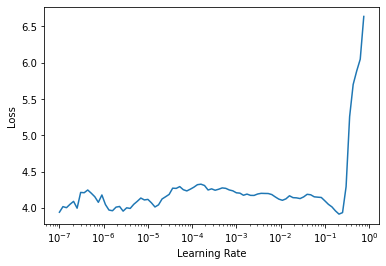

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(5, 1e-3)

epoch,train_loss,valid_loss,time
0,3.360527,0.809918,00:41
1,2.941194,0.618333,00:41
2,2.579051,0.721684,00:42
3,2.213678,0.500808,00:42
4,1.952536,0.420346,00:43


In [ ]:
learn.fit_flat_cos(5, 1e-3)

epoch,train_loss,valid_loss,time
0,1.580654,0.378692,00:43
1,1.340814,0.297345,00:42
2,1.121054,0.248737,00:43
3,0.921439,0.229253,00:43
4,0.778887,0.248350,00:43


In [ ]:
learn.fit_flat_cos(10, 1e-3)

epoch,train_loss,valid_loss,time
0,3.613755,1.136966,00:43
1,3.126917,0.831101,00:42
2,2.690712,0.605644,00:43
3,2.242980,0.454743,00:42
4,1.912802,0.460630,00:42
5,1.542380,0.378107,00:41
6,1.256466,0.294068,00:41
7,1.055275,0.266182,00:41
8,0.886694,0.250471,00:40
9,0.779371,0.225217,00:41


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=1.3182567499825382e-06)

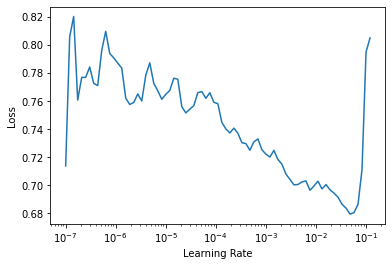

In [ ]:
learn.lr_find()

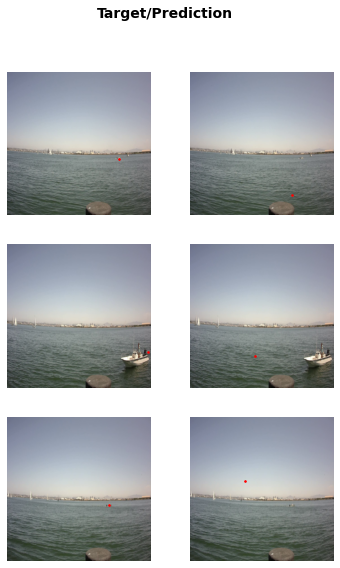

In [ ]:
learn.show_results()

# Softargmax

In [ ]:
import torch
import torch.nn as nn

def soft_argmax(voxels):
  """
  Arguments: voxel patch in shape (batch_size, channel, H, W)
  """
  assert voxels.dim()==4
  # alpha is here to make the largest element really big, so it
  # would become very close to 1 after softmax
  alpha = 1.0
  voxels = voxels[:, 0]
  N,H,W = voxels.shape
  soft_max = nn.functional.softmax(voxels.view(N,-1)*alpha,dim=1)
  soft_max = soft_max.view(voxels.shape)
  indices_kernelX = torch.arange(start=0,end=H, device=voxels.device)[None, :, None]
  indices_kernelY = torch.arange(start=0,end=W, device=voxels.device)[None, None, :]
  i0 = soft_max*indices_kernelX
  i1 = soft_max*indices_kernelY
  coords = torch.stack([i0.sum(dim=1).sum(dim=1) / H * 2 - 1,i1.sum(dim=1).sum(dim=1) / W * 2 - 1],dim=1)
  return coords.unsqueeze(1)


class SoftargmaxHead(torch.nn.Module):
    def forward(self, x):
      return soft_argmax(x)
X, y = dls.one_batch()
soft_argmax(X).shape

torch.Size([16, 1, 2])

In [ ]:
body = create_body(resnet18, pretrained=True)
head = SoftargmaxHead()
arch = nn.Sequential(body, head)
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)
learn = Learner(dls, arch, loss_func=MSELossFlat(),
                opt_func=ranger)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#learn.summary()

In [ ]:
# learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.137499,0.113778,00:40
1,0.111300,0.057191,00:41
2,0.097045,0.068484,00:41
3,0.082957,0.058387,00:41
4,0.075370,0.057602,00:41
5,0.072069,0.041031,00:41
6,0.062354,0.053260,00:41
7,0.057852,0.045991,00:41
8,0.050565,0.033217,00:41
9,0.040938,0.033916,00:41


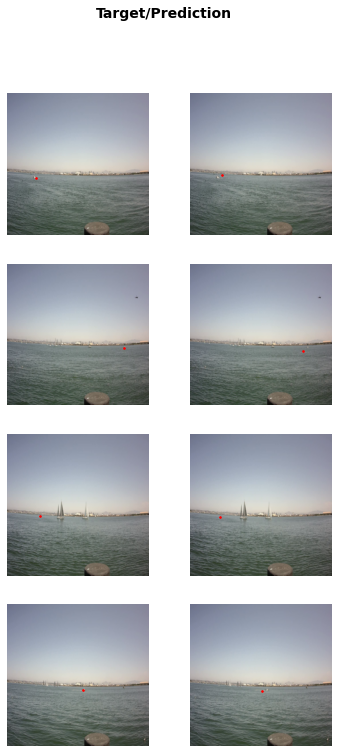

In [ ]:
learn.show_results(max_n=20)

# YOLO Softargmax


In [ ]:
! git clone https://github.com/ultralytics/yolov5
import sys
sys.path.append('yolov5')
from models.experimental import attempt_load
device = 'cuda'

Cloning into 'yolov5'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 2914 (delta 12), reused 17 (delta 7), pack-reused 2884
Receiving objects: 100% (2914/2914), 6.35 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (1925/1925), done.




Fusing layers... 


In [ ]:
model = attempt_load('yolov5s.pt', map_location=device)
model.model = nn.Sequential(*[mod for mod in model.model[:19]])
model

Fusing layers... 


Model(
  (model): Sequential(
    (0): Focus(
      (conv): Conv(
        (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): Hardswish()
      )
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): Hardswish()
    )
    (2): BottleneckCSP(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): Hardswish()
      )
      (cv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (cv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (cv4): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): Hardswish()
      )
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.1, inplace=True)
      (m): Sequential(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(1,

In [ ]:
imgs, y = dls.one_batch()

In [ ]:
model(imgs).shape

torch.Size([16, 128, 28, 28])

In [ ]:
body = model
head = SoftargmaxHead()
arch = nn.Sequential(body, head)
def _resnet_split(m): return L(m[0].model[:6], m[0].model[6:]).map(params)
learn = Learner(dls, arch, loss_func=MSELossFlat(), opt_func=ranger, splitter=_resnet_split)

In [ ]:
arch(imgs).shape

torch.Size([16, 1, 2])

In [ ]:
learn.summary()

Sequential (Input shape: ['16 x 3 x 448 x 448'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 32 x 224 x 224  3,488      True      
________________________________________________________________
Hardswish            16 x 32 x 224 x 224  0          False     
________________________________________________________________
Conv2d               16 x 64 x 112 x 112  18,496     True      
________________________________________________________________
Hardswish            16 x 64 x 112 x 112  0          False     
________________________________________________________________
Conv2d               16 x 32 x 112 x 112  2,080      True      
________________________________________________________________
Hardswish            16 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               16 x 32 x 112 x 112  2,048      True      
_________________________________________________

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=7.585775847473997e-07)

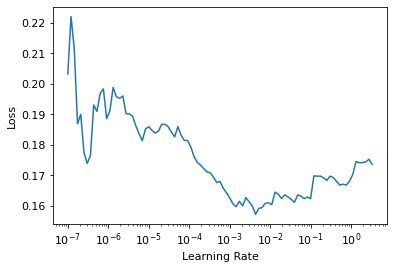

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.131284,0.107978,00:40
1,0.090767,0.089620,00:41
2,0.067455,0.099732,00:40
3,0.057569,0.068020,00:40
4,0.061929,0.114297,00:41
5,0.053773,0.048712,00:40
6,0.050773,0.057409,00:40
7,0.047557,0.052927,00:40
8,0.042024,0.035195,00:40
9,0.035294,0.037861,00:41


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.038764,0.041621,00:40
1,0.033829,0.041032,00:40
2,0.037952,0.048155,00:40
3,0.036563,0.037229,00:40
4,0.034138,0.026547,00:40


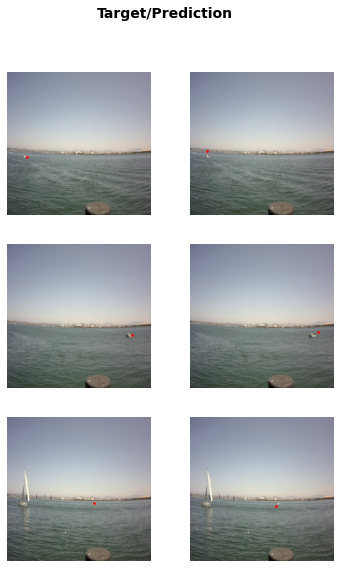

In [ ]:
learn.show_results()

# Softmax



In [ ]:
class SoftmaxHead(torch.nn.Module):
    def forward(self, x):
      """
      Arguments: x patch in shape (batch_size, channel, H, W)
      """
      voxels = x[:, 0]
      N,H,W = voxels.shape
      soft_max = nn.functional.softmax(voxels.view(N,-1),dim=1)
      soft_max = soft_max.view(voxels.shape)
      return soft_max


def Loss(x, y):
  N,H,W = x.shape
  i0 = ((y[:, 0, 0] * 0.5 + 0.5) * H).long()
  i1 = ((y[:, 0, 1] * 0.5 + 0.5) * W).long()
  i0 = torch.clamp(i0, 0, H - 1)
  i1 = torch.clamp(i1, 0, H - 1)
  logProbs = x[range(N), i0, i1]
  return -torch.log(logProbs + 1e-5).sum()

body = create_body(resnet18, pretrained=True)
head = SoftmaxHead()
arch = nn.Sequential(body, head)
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)
learn = Learner(dls, arch, loss_func=Loss, opt_func=ranger)
# learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(10, 1e-3)

KeyboardInterrupt: ignored

In [ ]:
X, y = dls.one_batch()

In [ ]:
yTilde = arch(X)

In [ ]:
N,H,W = yTilde.shape
i0 = ((y[:, 0, 0] * 0.5 + 0.5) * H).long()
i1 = ((y[:, 0, 1] * 0.5 + 0.5) * W).long()
i0 = torch.clamp(i0, 0, H - 1)
i1 = torch.clamp(i1, 0, H - 1)
logProbs = yTilde[range(N), i0, i1]
print(logProbs)
print(-torch.log(logProbs + 1e-5).sum())

TensorImage([9.8065e-01, 2.2984e-01, 1.1976e-02, 9.0058e-01, 9.4072e-01, 6.0289e-01,
        4.3072e-02, 1.0930e-01, 1.1099e-04, 2.0459e-01, 3.4885e-02, 9.5531e-01,
        9.1982e-01, 6.7901e-01, 4.5279e-01, 9.1730e-01], device='cuda:0',
       grad_fn=<AliasBackward>)
TensorImage(27.3008, device='cuda:0', grad_fn=<AliasBackward>)


In [ ]:
logProbs[9]

TensorImage(0.2046, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
i0[9], i1[9]

(TensorPoint(2, device='cuda:0'), TensorPoint(8, device='cuda:0'))

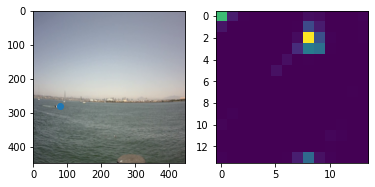

In [ ]:
i = 9
plt.subplot(1, 2, 1)
plt.imshow(X[i].cpu().numpy().transpose((1, 2, 0)))
plt.plot((y[i, 0, 0].item() / 2 + 0.5) * X.shape[2], (y[i, 0, 1].item() / 2 + 0.5) * X.shape[3], 'o')
plt.subplot(1, 2, 2)
plt.imshow(yTilde[i].detach().cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

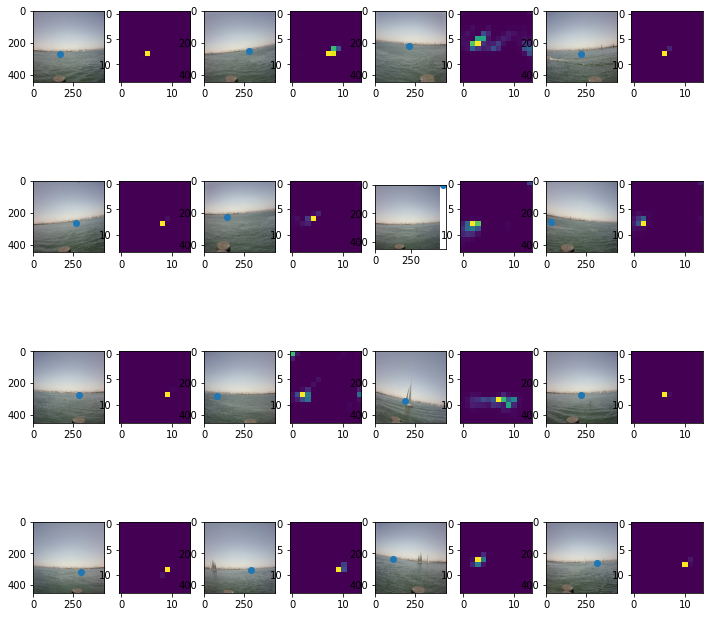

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(16):
  plt.subplot(4, 8, 2 * i + 1)
  plt.imshow(X[i].cpu().numpy().transpose((1, 2, 0)))
  plt.plot((y[i, 0, 0].item() / 2 + 0.5) * X.shape[2], (y[i, 0, 1].item() / 2 + 0.5) * X.shape[3], 'o')
  plt.subplot(4, 8, 2 * i + 2)
  plt.imshow(yTilde[i].detach().cpu().numpy().transpose((1, 0)))

In [ ]:
y[i].cpu().numpy()

array([[-0.02964871,  0.22450447]], dtype=float32)

In [ ]:
yTilde.shape

torch.Size([16, 14, 14])